# _Multi-label classification using deep learning algorithm_

## Importing Libraries

TASKS:

1. Reduce dataset size
2. upload on kaggle, split - done
3. look at deployment options - flask

In [1]:
import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers import Activation, Dropout, Convolution2D, GlobalAveragePooling2D
from keras.models import Sequential
import tensorflow as tf
import tensorflow.keras.applications.mobilenet
import os

In [2]:
IMG_SAVE_PATH = r'C:\Users\hp\Downloads\ISIC\ISIC_2019_Training_Input\Split_smol\train' 

In [3]:
Str_to_Int = {
    'Actinic keratosis': 0,
    'Atopic Dermatitis': 1,
    'Benign keratosis': 2,
    'Dermatofibroma': 3,
    'Melanocytic nevus': 4,
    'Melanoma':5,
    'Squamous cell carcinoma': 6,
    'Tinea Ringworm Candidiasis':7,
    'Vascular lesion': 8
}

NUM_CLASSES = 9


def str_to_Int_mapper(val):
    return Str_to_Int[val]

In [4]:
import PIL
import cv2 

dataset = []
for directory in os.listdir(IMG_SAVE_PATH):
    path = os.path.join(IMG_SAVE_PATH, directory)
    for image in os.listdir(path):
        new_path = os.path.join(path, image)
        try:
            imgpath=PIL.Image.open(new_path)
            #if imgpath.shape!=(240,240,3):
            imgpath=imgpath.convert('RGB')
            img = np.asarray(imgpath)
            img = cv2.resize(img, (240,240))
            img=img/255.
            dataset.append([img, directory]) 
        except FileNotFoundError:
            print('Image file not found. Skipping...')

Image file not found. Skipping...


In [5]:
data, labels = zip(*dataset)
temp = list(map(str_to_Int_mapper, labels))

In [6]:
#data[0]

In [7]:
import keras
labels = keras.utils.to_categorical(temp)

In [8]:
count=0
for i in data:
    if i.shape!=(240, 240, 3):
        count=count+1
print(count)      

0


## DenseNet

In [9]:
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras import layers

densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(240,240,3)
)

def build_densenet():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(9, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [10]:
model = build_densenet()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 9)                 9225      
                                                                 
Total params: 7,046,729
Trainable params: 6,963,081
Non-trainable params: 83,648
_________________________________________________________________


In [11]:
history=model.fit(np.array(data), np.array(labels), epochs = 5, shuffle = True, validation_split = 0.2)

Epoch 1/5
18/18 [==============================] - 1073s 57s/step - loss: 0.8658 - accuracy: 0.1781 - val_loss: 0.7085 - val_accuracy: 0.1929
Epoch 2/5
18/18 [==============================] - 942s 52s/step - loss: 0.6246 - accuracy: 0.3633 - val_loss: 0.6708 - val_accuracy: 0.2000
Epoch 3/5
18/18 [==============================] - 851s 47s/step - loss: 0.4862 - accuracy: 0.4838 - val_loss: 0.6658 - val_accuracy: 0.2071
Epoch 4/5
18/18 [==============================] - 896s 49s/step - loss: 0.3750 - accuracy: 0.6133 - val_loss: 0.6484 - val_accuracy: 0.2357
Epoch 5/5
18/18 [==============================] - 911s 51s/step - loss: 0.2915 - accuracy: 0.7446 - val_loss: 0.6098 - val_accuracy: 0.1929


In [12]:
import seaborn as sns
from matplotlib import pyplot
    
def plot_acc(history):
    sns.set()

    fig = pyplot.figure(0, (12, 4))

    ax = pyplot.subplot(1, 2, 1)
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
    pyplot.title('Accuracy')
    pyplot.tight_layout()

    ax = pyplot.subplot(1, 2, 2)
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
    pyplot.title('Loss')
    pyplot.tight_layout()

    pyplot.show()

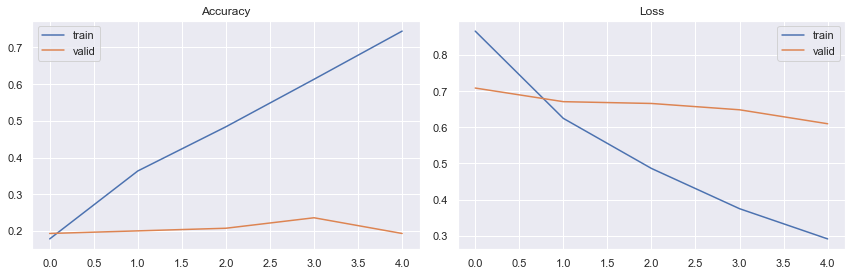

In [13]:
plot_acc(history)

## Mobilenet

In [14]:
def mobilenet():
    model = Sequential([
        tf.keras.applications.mobilenet.MobileNet(input_shape=(240,240, 3), include_top=False),
        Dropout(0.5),
        Convolution2D(9, (1, 1), padding='valid'),
        Activation('relu'),        # Rectified Linear Unit - Activation Function
        GlobalAveragePooling2D(),  # Pooling Layer
        Activation('softmax')      # Softmax - Activation Function - For Multi Class Classification
    ])
    return model

In [15]:
# define the model
model_mobile = mobilenet()
model_mobile.compile(
    optimizer=Adam(learning_rate=0.0001),         # lr = learning_rate
    loss='categorical_crossentropy',   # Multi-class classification
    metrics=['accuracy']  
)

In [16]:
model_mobile.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 1024)        0         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 9)           9225      
                                                                 
 activation (Activation)     (None, 7, 7, 9)           0         
                                                                 
 global_average_pooling2d_1   (None, 9)                0         
 (GlobalAveragePooling2D)                                        
                                                                 
 activation_1 (Activation)   (None, 9)                

In [17]:
history_mobile=model_mobile.fit(np.array(data), np.array(labels), epochs = 5, shuffle = True, validation_split = 0.3)

Epoch 1/5
16/16 [==============================] - 191s 11s/step - loss: 2.0261 - accuracy: 0.3080 - val_loss: 2.9103 - val_accuracy: 0.1196
Epoch 2/5
16/16 [==============================] - 153s 10s/step - loss: 0.7432 - accuracy: 0.7967 - val_loss: 3.5524 - val_accuracy: 0.0000e+00
Epoch 3/5
16/16 [==============================] - 157s 10s/step - loss: 0.3405 - accuracy: 0.9158 - val_loss: 3.3401 - val_accuracy: 0.0000e+00
Epoch 4/5
16/16 [==============================] - 151s 9s/step - loss: 0.1954 - accuracy: 0.9630 - val_loss: 3.3552 - val_accuracy: 0.0048
Epoch 5/5
16/16 [==============================] - 136s 9s/step - loss: 0.1034 - accuracy: 0.9815 - val_loss: 3.4380 - val_accuracy: 0.0096


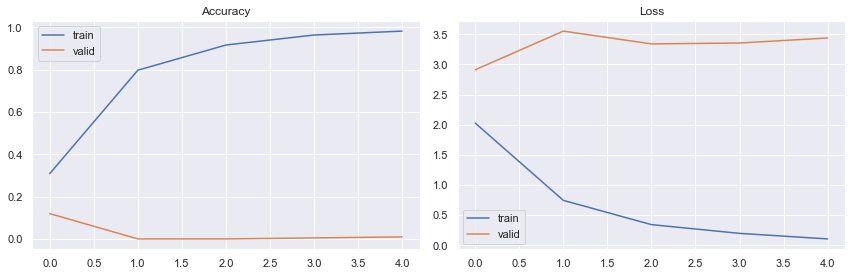

In [18]:
plot_acc(history_mobile)

## CNN

In [19]:
def cnn():
    model=Sequential()

    model.add(Conv2D(8, kernel_size=(3,3), activation='relu', input_shape=(240,240,3)))
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(9, activation='softmax'))
    
    return model

In [20]:
from keras.layers import Dense , Dropout , Conv2D , MaxPooling2D, Flatten
model_cnn=cnn()
model_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),         # lr = learning_rate
    loss='categorical_crossentropy',   # Multi-class classification
    metrics=['accuracy']  
)

In [21]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 238, 238, 8)       224       
                                                                 
 conv2d_2 (Conv2D)           (None, 236, 236, 16)      1168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 118, 118, 16)     0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 118, 118, 16)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 116, 116, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 58, 32)       0         
 2D)                                                  

In [22]:
history_cnn=model_cnn.fit(np.array(data), np.array(labels), epochs = 5, shuffle = True, validation_split = 0.25)

Epoch 1/5
17/17 [==============================] - 61s 3s/step - loss: 2.1070 - accuracy: 0.1360 - val_loss: 2.7620 - val_accuracy: 0.0000e+00
Epoch 2/5
17/17 [==============================] - 56s 3s/step - loss: 2.0200 - accuracy: 0.1724 - val_loss: 2.7889 - val_accuracy: 0.0000e+00
Epoch 3/5
17/17 [==============================] - 56s 3s/step - loss: 2.0314 - accuracy: 0.1858 - val_loss: 2.6704 - val_accuracy: 0.0000e+00
Epoch 4/5
17/17 [==============================] - 62s 4s/step - loss: 1.9942 - accuracy: 0.2050 - val_loss: 2.8081 - val_accuracy: 0.0000e+00
Epoch 5/5
17/17 [==============================] - 58s 3s/step - loss: 1.9680 - accuracy: 0.2011 - val_loss: 2.8076 - val_accuracy: 0.0000e+00


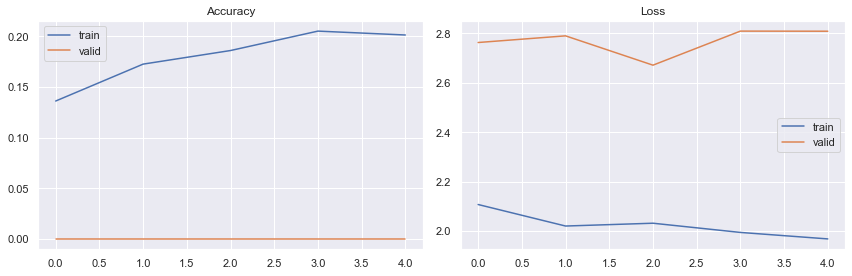

In [23]:
plot_acc(history_cnn)

## Save model

In [24]:
# save the model for later use
model.save("skin_disease_model_ISIC_densenet.h5")

## Evaluate Models

In [25]:
IMG_SAVE_PATH_TESTING = r'C:\Users\hp\Downloads\ISIC\ISIC_2019_Training_Input\Split_smol\val'

In [26]:
import PIL
import cv2
dataset_testing = []
for directory in os.listdir(IMG_SAVE_PATH_TESTING):
    path = os.path.join(IMG_SAVE_PATH_TESTING, directory)
    for image in os.listdir(path):
        new_path = os.path.join(path, image)
        imgpath=PIL.Image.open(new_path)
        #if imgpath.shape!=(240,240,3):
        imgpath=imgpath.convert('RGB')
        img = np.asarray(imgpath)
#         img = cv2.imread(new_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (240, 240))
        img=img/255.
        dataset_testing.append([img, directory]) 

In [27]:
testing_data, testing_labels = zip(*dataset_testing)
testing_temp = list(map(str_to_Int_mapper, testing_labels))

In [28]:
import keras
testing_labels = keras.utils.to_categorical(testing_temp)

In [29]:
model.evaluate(np.array(testing_data), np.array(testing_labels))

6/6 [==============================] - 45s 7s/step - loss: 0.5804 - accuracy: 0.3536


[0.5804032683372498, 0.3535911738872528]

In [30]:
model_mobile.evaluate(np.array(testing_data), np.array(testing_labels))

6/6 [==============================] - 11s 2s/step - loss: 1.9972 - accuracy: 0.4144


[1.9972120523452759, 0.41436463594436646]

In [31]:
model_cnn.evaluate(np.array(testing_data), np.array(testing_labels))

6/6 [==============================] - 4s 598ms/step - loss: 2.2117 - accuracy: 0.2431


[2.2116811275482178, 0.24309392273426056]

## Prediction

In [32]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
import scikitplot

# Make predictions
def make_preds(model):
    label_preds = model.predict(np.array(testing_data))

    def one_hot_highest(arr):
        for row in arr:
            max_val = max(row)
            for i in range(len(row)):
                if row[i] == max_val:
                    row[i] = 1
                else:
                    row[i] = 0
        return arr

    arr=one_hot_highest(label_preds) #one hot
    arr2= one_hot_highest(testing_labels)

    labelenc=[]
    for i in range (0, len(arr)):
        flag=0
        for j in range (0,9):
            if arr[i][j]==1:
                labelenc.append(j)
                flag=1 
    labelenctest=[]
    for i in range (0, len(arr2)):
        for j in range (0,9):
            if arr2[i][j]==1:
                labelenctest.append(j)

    scikitplot.metrics.plot_confusion_matrix(labelenctest,labelenc)

6/6 [==============================] - 43s 6s/step


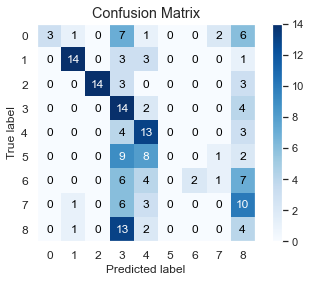

In [33]:
make_preds(model)

6/6 [==============================] - 9s 1s/step


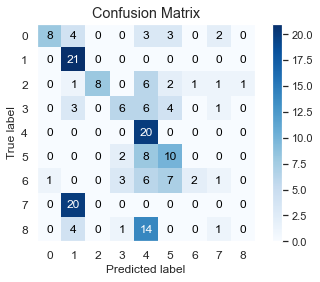

In [34]:
make_preds(model_mobile)

6/6 [==============================] - 4s 696ms/step


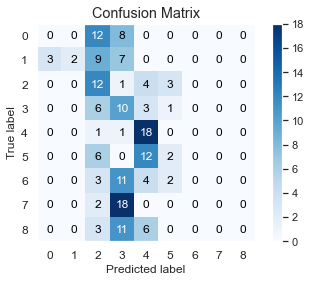

In [35]:
make_preds(model_cnn)